In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-11-23 01:12:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-23 01:12:57 (86.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys


In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-11-23 01:13:01--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.29MB/s    in 0.4s    

2023-11-23 01:13:02 (1.29 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



# Visualize dataset

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df_shuffled = train_df.sample(
    frac=1, random_state=42
)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


# Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled['text'],
    train_df_shuffled['target'],
    test_size=0.2, random_state=42
)

In [ ]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)
train_sentences.shape

(6090,)

# Converting text into numbers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_m

In [ ]:
# Find average number of tokens (words) in training Tweets

word_avg = round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

In [ ]:
max_vocab_length = 10000
max_length = word_avg

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length
)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[240,   3, 229,   4,  13, 724,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it

import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Some poor sods arriving in Amman during yesterday's dust storm were diverted to Ben Gurion airport: http://t.co/jkpjpcH9i6      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  82,  841, 7677, 5698,    4,    1,  245, 3868,  342,   81,   68,
           1,    5, 1574,    1]])>

## Creating an Embedding using an Embedding Layer

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [ ]:
random_sentence = random.choice(train_sentences)

print(f"Original text: \n{random_sentence}\
      \n\nEmbedded version: ")

# Embed the random sentences
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
Carl Everest Rob Cobes Whitt Blight Frost Leo Snuff Godly and a few others. I will drink a beer with them. Someday.      

Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00489117, -0.02911158, -0.04753783, ..., -0.04871768,
          0.01729182, -0.00811198],
        [-0.00489117, -0.02911158, -0.04753783, ..., -0.04871768,
          0.01729182, -0.00811198],
        [ 0.04691455,  0.03432434,  0.00575598, ...,  0.03150475,
          0.00078202,  0.01157963],
        ...,
        [ 0.04934588, -0.01317589,  0.02074425, ..., -0.03727432,
         -0.0494691 ,  0.03823039],
        [-0.02379632,  0.00038698, -0.02766494, ..., -0.00282214,
         -0.00907195, -0.03872292],
        [-0.02731439, -0.03368596,  0.01288897, ...,  0.03599591,
          0.0357444 ,  0.04695709]]], dtype=float32)>

In [ ]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-4.89116833e-03, -2.91115772e-02, -4.75378297e-02, -1.93545707e-02,
        4.66554798e-02, -3.19898278e-02,  7.15676695e-03,  3.64756584e-03,
        2.67355517e-03, -3.67486477e-03, -4.59033251e-03, -8.12041759e-03,
       -1.34996288e-02,  1.71076320e-02, -1.93532947e-02,  8.58237594e-03,
       -3.16649675e-03,  4.64196540e-02,  7.87352398e-03,  3.19582261e-02,
        3.32164802e-02,  4.14228439e-03,  2.79752947e-02,  1.55091174e-02,
        4.91332524e-02,  1.04498155e-02,  1.22241154e-02,  1.65772699e-02,
       -3.20874676e-02,  3.36026028e-03,  2.73292325e-02,  4.12779935e-02,
       -2.39240415e-02,  3.01724188e-02,  1.55929960e-02,  3.01909707e-02,
        2.99930684e-02,  2.78637558e-03,  1.97444111e-03, -2.93197986e-02,
        1.81754716e-02, -2.47163530e-02, -3.64809036e-02,  3.67598198e-02,
       -3.52717154e-02,  1.50913931e-02, -8.90433788e-04,  1.73955821e-02,
       -2.20102072e-02,  2.65134610e-02, -4.69503552

## Model 0: Getting baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")


Our baseline model achieves an accuracy of: 79.91%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function for our model experiments

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.9080761654629,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629,
 'f1': 0.7920155324845473}

## Model 1: A simple dense model

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1')

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080

In [ ]:
train_labels

2710    0
3250    1
78      1
1621    1
2528    0
       ..
7090    1
629     0
6464    1
6265    1
3723    0
Name: target, Length: 6090, dtype: int64

In [ ]:
model_1_history = model_1.fit(
    train_sentences,
    train_labels,
    epochs=10,
    validation_data=(val_sentences, val_labels)
)

Epoch 1/10
191/191 [==============================] - 22s 60ms/step - loss: 0.5613 - accuracy: 0.7061 - val_loss: 0.4612 - val_accuracy: 0.7814
Epoch 2/10
191/191 [==============================] - 3s 15ms/step - loss: 0.3277 - accuracy: 0.8683 - val_loss: 0.4666 - val_accuracy: 0.7971
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2122 - accuracy: 0.9190 - val_loss: 0.5666 - val_accuracy: 0.7656
Epoch 4/10
191/191 [==============================] - 2s 11ms/step - loss: 0.1405 - accuracy: 0.9493 - val_loss: 0.6423 - val_accuracy: 0.7551
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0980 - accuracy: 0.9612 - val_loss: 0.7930 - val_accuracy: 0.7833
Epoch 6/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0787 - accuracy: 0.9681 - val_loss: 0.9308 - val_accuracy: 0.7511
Epoch 7/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0649 - accuracy: 0.9719 - val_loss: 0.9861 - val_accuracy: 0.7617

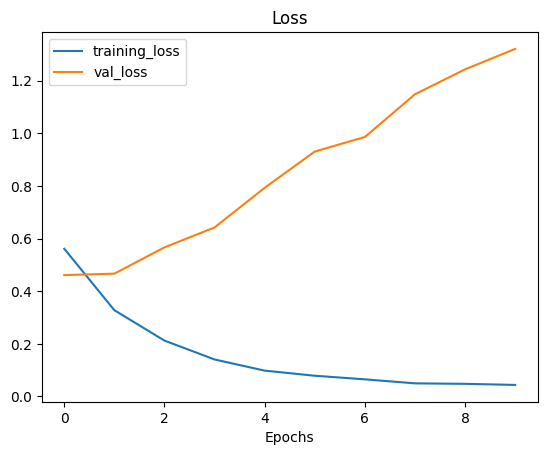

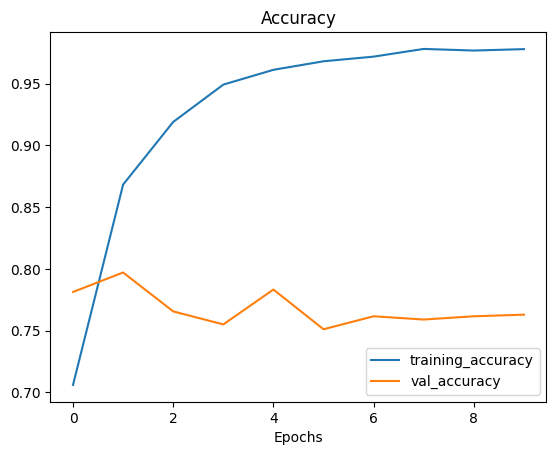

In [ ]:
plot_loss_curves(model_1_history)

# Model 2: TensorFlow Hub Pretrained Sentence Encoder

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
senteces_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name='USE'

)

In [ ]:
from tensorflow.keras import layers

model_2 = tf.keras.Sequential([
    senteces_encoder_layer,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
], name='model_2_USE')

# Compile model
model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_2.summary()


Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                

In [ ]:
# Train a classifier on top of pretrained embeddings
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels)
                              )

Epoch 1/5
191/191 [==============================] - 12s 28ms/step - loss: 0.6478 - accuracy: 0.6079 - val_loss: 0.5023 - val_accuracy: 0.7905
Epoch 2/5
191/191 [==============================] - 3s 18ms/step - loss: 0.5137 - accuracy: 0.7744 - val_loss: 0.4464 - val_accuracy: 0.8011
Epoch 3/5
191/191 [==============================] - 3s 18ms/step - loss: 0.4683 - accuracy: 0.8059 - val_loss: 0.4378 - val_accuracy: 0.8011
Epoch 4/5
191/191 [==============================] - 4s 23ms/step - loss: 0.4534 - accuracy: 0.8204 - val_loss: 0.4328 - val_accuracy: 0.8129
Epoch 5/5
191/191 [==============================] - 4s 21ms/step - loss: 0.4250 - accuracy: 0.8292 - val_loss: 0.4310 - val_accuracy: 0.8109


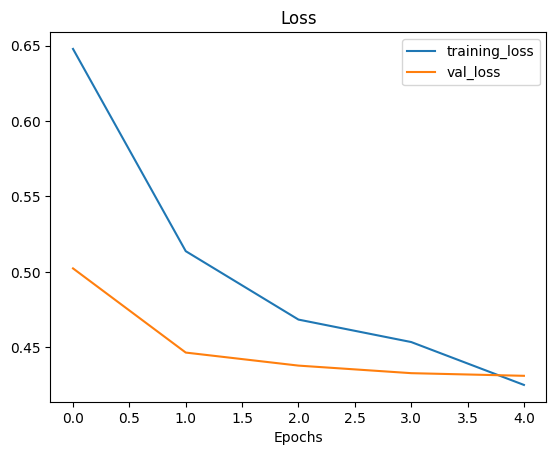

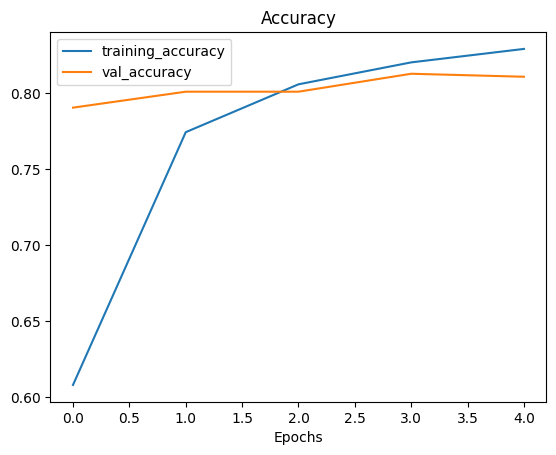

In [ ]:
plot_loss_curves(model_2_history)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2.predict(val_sentences)))
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

48/48 [==============================] - 1s 11ms/step


{'accuracy': 81.08995403808274,
 'precision': 0.8158706714549643,
 'recall': 0.8108995403808273,
 'f1': 0.8074723541855477}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "tf_hub_sentence_encoder": model_2_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.908076,0.814636,0.799081,0.792016
tf_hub_sentence_encoder,81.089954,0.815871,0.810900,0.807472


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100


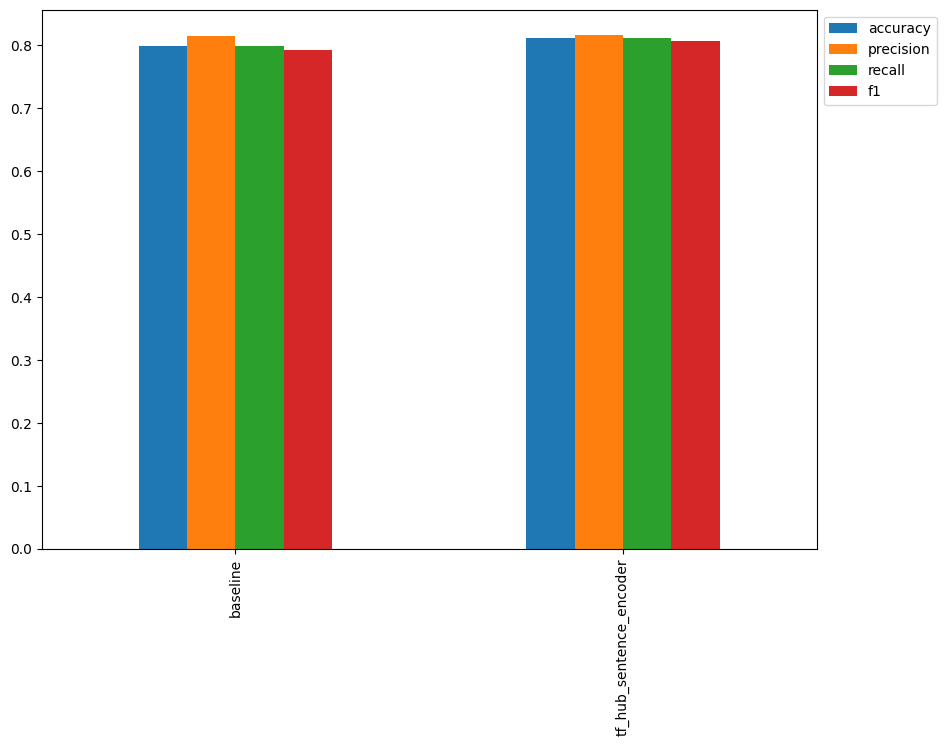

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


## Finding the most wrong examples

In [ ]:
import pandas as pd

val_df = pd.DataFrame({
    'text': val_sentences,
    'target': val_labels,
    "pred": model_2_preds,
    "pred_prob": tf.squeeze(model_2.predict(val_sentences))
})

val_df

48/48 [==============================] - 1s 19ms/step


,text,target,pred,pred_prob
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.253847
584,FedEx no longer to transport bioterror germs i...,0,1.0,0.781709
7411,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986643
5950,@camilacabello97 Internally and externally scr...,1,0.0,0.229280
5541,Radiation emergency #preparedness starts with ...,1,1.0,0.549668
...,...,...,...,...
6204,@SidelineSavage what like a pipe made of peanu...,0,0.0,0.111009
544,Avalanche City - Sunset http://t.co/48h3tLvLXr...,1,0.0,0.273783
7287,The Whirlwind! Scourge of Europe! RT @whedones...,0,0.0,0.351001
6042,ENGLAND EAST COAST. Dogger Bank Westward. 1. S...,0,0.0,0.431979


In [ ]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong

,text,target,pred,pred_prob
3954,@adorableappple No reported flooding po in the...,0,1.0,0.984280
397,Mourning notices for stabbing arson victims st...,0,1.0,0.955603
1206,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.948476
7330,We should all have a fire safety plan. RT @Mat...,0,1.0,0.944210
5147,Aug. 5: The Fort Calhoun Nuclear Station is at...,0,1.0,0.921455
...,...,...,...,...
2544,destroy the free fandom honestly,1,0.0,0.067105
1005,'I did another one I did another one. You stil...,1,0.0,0.055361
361,VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP ...,1,0.0,0.054812
2250,Why are you deluged with low self-image? Take ...,1,0.0,0.041773


In [ ]:
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")


Target: 0, Pred: 1, Prob: 0.9842803478240967
Text:
@adorableappple No reported flooding po in the area. Ten-4. #mmda

----

Target: 0, Pred: 1, Prob: 0.955603301525116
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe

----

Target: 0, Pred: 1, Prob: 0.9484761953353882
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9442098736763
Text:
We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv

----

Target: 0, Pred: 1, Prob: 0.9214550256729126
Text:
Aug. 5: The Fort Calhoun Nuclear Station is at 100% capacity today according to the NRC: http://t.co/pztbQImpuW

----

Target: 0, Pred: 1, Prob: 0.9076107740402222
Text:
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW

----

Target: 0

## Make predictions

In [ ]:
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob))
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [ ]:
tweet = "The tornado destoyed my home"
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_2, # use the USE model
                    sentence=tweet)

1/1 [==============================] - 1s 685ms/step
Pred: 1.0 (real disaster) Prob: 0.6289676427841187
Text:
The tornado destoyed my home


# Twitter sentiment analysis

In [2]:

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

100% 1.99M/1.99M [00:00<00:00, 2.63MB/s]
100% 1.99M/1.99M [00:00<00:00, 2.33MB/s]


In [3]:
# Import Required libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, SpatialDropout1D, Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys


--2023-11-24 02:50:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-24 02:50:24 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
unzip_data('/content/twitter-entity-sentiment-analysis.zip')

In [6]:
import pandas as pd
train_df = pd.read_csv('/content/twitter_training.csv')
val_df = pd.read_csv('/content/twitter_validation.csv')

## Preprocess data

In [7]:
# Renaming Columns name
colnames=['TweetId', 'Entity', 'Output', 'Tweet']
train_df.columns = colnames
val_df.columns = colnames

train_df

,TweetId,Entity,Output,Tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [8]:
val_df

,TweetId,Entity,Output,Tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [9]:
# Check null values
null_values = train_df.isnull().any(axis=1)
train_df[null_values]

,TweetId,Entity,Output,Tweet
60,2411,Borderlands,Neutral,NaN
552,2496,Borderlands,Neutral,NaN
588,2503,Borderlands,Neutral,NaN
744,2532,Borderlands,Positive,NaN
1104,2595,Borderlands,Positive,NaN
...,...,...,...,...
73971,9073,Nvidia,Positive,NaN
73972,9073,Nvidia,Positive,NaN
74420,9154,Nvidia,Positive,NaN
74421,9154,Nvidia,Positive,NaN


In [10]:
# Drop na values
train_df = train_df.dropna()

In [11]:
train_df.isnull().value_counts()

TweetId  Entity  Output  Tweet
False    False   False   False    73995
dtype: int64

In [12]:
train_df.shape

(73995, 4)

In [13]:

# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,TweetId,Entity,Output,Tweet
61734,4984,GrandTheftAuto(GTA),Irrelevant,Do you think you can hurt me?
11260,13136,Xbox(Xseries),Positive,About The time!!
55969,11207,TomClancysRainbowSix,Neutral,Calls from _ z1rv _ & @ Tweet98 got me this so...
4111,1909,CallOfDutyBlackopsColdWar,Negative,So CoD: Black Ops Cold War is gonna be ass? @ ...
2308,1604,CallOfDutyBlackopsColdWar,Negative,Y HAPPY ABOUT THIS.


## Visualize data

In [14]:
len(train_df_shuffled), train_df_shuffled.shape

(73995, (73995, 4))

In [15]:
train_df_shuffled['Output'].value_counts()

Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: Output, dtype: int64

In [16]:
train_df_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73995 entries, 61734 to 15956
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TweetId  73995 non-null  int64 
 1   Entity   73995 non-null  object
 2   Output   73995 non-null  object
 3   Tweet    73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


## SPlit data

In [17]:

from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["Tweet"].to_numpy(),
                                                                            train_df_shuffled["Output"].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility


In [18]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(59196, 59196, 14799, 14799)

In [19]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(["I haven't bought Madden in 4 years but I'm buying this one fam! Congratulations!!! Hard work pays off!!!!",
        'If it just takes "a few of days" for Android developers to recompile existing x86 intel based apps for iOS that\'s good. I expect Microsoft & Adobe are in the category that takes a bit longer. Happy to hear they\'re already working on it!',
        'I love seeing Naughty Dog fanboys squirm every time Cyberpunk 2077 gets brought up. They are desperate for it to fail, it’s pathetic. https://t.co/WrII1g5jDs',
        "@PUBG_Support Hiya! So when'll u be fixing your f'n console game? Been asking a lot and have been very satisfied with your lack of responses .  Just wondering if lagouts are a part of the game like red zones and I'm just not aware or if you just can't fix a 2 year + problem. Thx!",
        'Freight team did a awesome job recovering A/c and fans .. great weekend with sales !!! ',
        '... store.playstation.com /',
        '4 games 4 tags.. 1. Dota 

## Converting text into numbers

In [20]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))


19

In [21]:
from tensorflow.keras.layers import TextVectorization
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [22]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [23]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 19), dtype=int64, numpy=
array([[ 700,    6, 5920,   10,   15, 1646,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])>

In [24]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")


Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'i', 'to']
Bottom 5 least common words: ['allison', 'alignment', 'algeria', 'alexstone7', 'alabama']


## Creating an Embedding using an Embedding Layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input

embedding


In [26]:
 # Get a random sentence from training set
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed


Original text:
Looks like DICE may be working toward rolling back PvP Operations to the BF1 Operations setup w/ Battalions and cinematic intros... Leaving this stage though... is it really into it?.. Fine so you're going to do this 3 months after launch listening to feedback, but 17 months after launch?     

Embedded version:


<tf.Tensor: shape=(1, 19, 128), dtype=float32, numpy=
array([[[ 0.02149474,  0.04575339,  0.03511181, ..., -0.03180654,
          0.04774303, -0.04565025],
        [ 0.01413281,  0.02640655,  0.00598471, ..., -0.0286643 ,
          0.04175551,  0.00527921],
        [ 0.01724802, -0.01753236, -0.01064174, ...,  0.03069292,
         -0.04579289, -0.04914922],
        ...,
        [ 0.02759996, -0.03738177,  0.03063506, ..., -0.01432896,
          0.02592579,  0.00291629],
        [-0.02407775, -0.02015354,  0.0385336 , ...,  0.00253104,
          0.03650192,  0.02685851],
        [ 0.03002045, -0.03188081, -0.02007794, ..., -0.01226782,
          0.04947641,  0.04183442]]], dtype=float32)>

In [27]:
train_labels.shape, train_sentences.shape

((59196,), (59196,))

# Model 0

In [28]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")


Our baseline model achieves an accuracy of: 73.34%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]


array(['Neutral', 'Positive', 'Negative', 'Positive', 'Irrelevant',
       'Positive', 'Irrelevant', 'Positive', 'Positive', 'Positive',
       'Negative', 'Negative', 'Positive', 'Negative', 'Negative',
       'Negative', 'Neutral', 'Negative', 'Irrelevant', 'Neutral'],
      dtype='<U10')

In [31]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [32]:

# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 73.33603621866342,
 'precision': 0.7739122613984681,
 'recall': 0.7333603621866343,
 'f1': 0.7229200275334022}

## Baseline

In [33]:

import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])
senteces_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name='USE'

)

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [34]:
embedded_sample = embed([sample_sentence])[0]
print(embedded_sample[:50])

tf.Tensor(
[-0.01157027  0.02485911  0.02878049 -0.01271501  0.0397154   0.08827761
  0.02680985  0.05589838 -0.01068731 -0.0059729   0.00639323 -0.01819521
  0.00030817  0.09105889  0.05874642 -0.03180628  0.01512472 -0.05162928
  0.00991366 -0.06865346 -0.04209308  0.0267898   0.03011007  0.00321065
 -0.00337969 -0.04787356  0.02266722 -0.00985928 -0.04063612 -0.01292093
 -0.04666385  0.05630299 -0.03949254  0.00517688  0.02495828 -0.07014439
  0.02871511  0.04947681 -0.00633974 -0.08960193  0.02807117 -0.00808362
 -0.01360602  0.05998651 -0.10361787 -0.05195372  0.00232956 -0.02332529
 -0.03758107  0.0332773 ], shape=(50,), dtype=float32)


In [35]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to integer format
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

In [36]:
train_labels_encoded

array([2, 2, 0, ..., 1, 1, 3])

In [109]:
val_labels_encoded[:10], val_labels[:10]

(array([2, 3, 1, 3, 0, 3, 0, 3, 3, 3]),
 array(['Neutral', 'Positive', 'Negative', 'Positive', 'Irrelevant',
        'Positive', 'Irrelevant', 'Positive', 'Positive', 'Positive'],
       dtype=object))

In [37]:
from tensorflow.keras import layers, Sequential

model_2 = Sequential([
    senteces_encoder_layer,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
], name='model_2_USE')

model_2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_2.summary()



Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                

In [38]:
train_labels_encoded[:10], train_labels[:10]

(array([2, 2, 0, 1, 3, 0, 2, 2, 1, 3]),
 array(['Neutral', 'Neutral', 'Irrelevant', 'Negative', 'Positive',
        'Irrelevant', 'Neutral', 'Neutral', 'Negative', 'Positive'],
       dtype=object))

In [39]:
model_2_history = model_2.fit(train_sentences,
                              train_labels_encoded,
                              epochs=10,  # Increase the number of epochs
                              validation_data=(val_sentences, val_labels_encoded))

Epoch 1/10
1850/1850 [==============================] - 39s 17ms/step - loss: 1.1755 - accuracy: 0.5041 - val_loss: 1.0129 - val_accuracy: 0.5948
Epoch 2/10
1850/1850 [==============================] - 31s 17ms/step - loss: 1.0633 - accuracy: 0.5724 - val_loss: 0.9370 - val_accuracy: 0.6238
Epoch 3/10
1850/1850 [==============================] - 33s 18ms/step - loss: 1.0031 - accuracy: 0.6035 - val_loss: 0.8757 - val_accuracy: 0.6475
Epoch 4/10
1850/1850 [==============================] - 31s 17ms/step - loss: 0.9547 - accuracy: 0.6271 - val_loss: 0.8396 - val_accuracy: 0.6729
Epoch 5/10
1850/1850 [==============================] - 31s 17ms/step - loss: 0.9085 - accuracy: 0.6512 - val_loss: 0.8105 - val_accuracy: 0.6865
Epoch 6/10
1850/1850 [==============================] - 32s 17ms/step - loss: 0.8687 - accuracy: 0.6708 - val_loss: 0.7764 - val_accuracy: 0.6969
Epoch 7/10
1850/1850 [==============================] - 33s 18ms/step - loss: 0.8427 - accuracy: 0.6815 - val_loss: 0.7496 -

In [40]:
model_2_preds = tf.argmax(model_2.predict(val_sentences), axis=1)
model_2_preds[:10]

463/463 [==============================] - 5s 11ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 1, 3, 0, 3, 0, 3, 3, 3])>

In [41]:
val_labels[:10], val_labels_encoded[:10]

(array(['Neutral', 'Positive', 'Negative', 'Positive', 'Irrelevant',
        'Positive', 'Irrelevant', 'Positive', 'Positive', 'Positive'],
       dtype=object),
 array([2, 3, 1, 3, 0, 3, 0, 3, 3, 3]))

In [42]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 73.95094263125887,
 'precision': 0.7397032077403062,
 'recall': 0.7395094263125886,
 'f1': 0.7356756028320026}

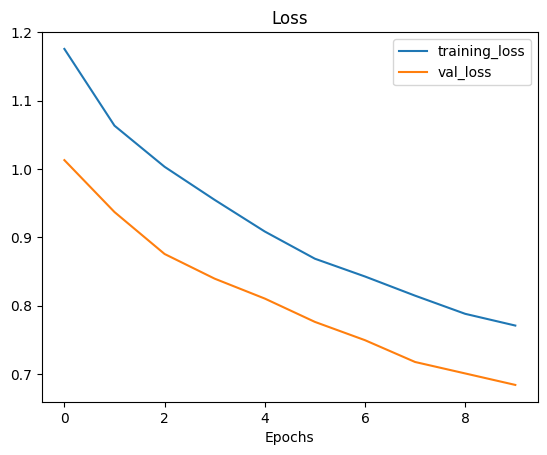

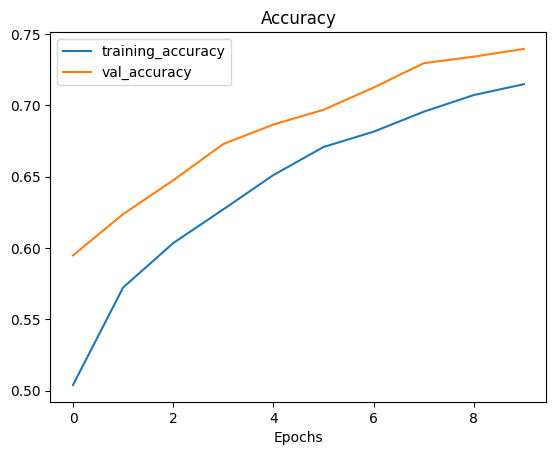

In [43]:
plot_loss_curves(model_2_history)

## Model 3: Conv1d

In [44]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1d')

model_3.compile(
   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


model_3.summary()


Model: "model_3_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 15, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 32)             

In [45]:
model_3_history = model_3.fit(train_sentences,
                              train_labels_encoded,
                              epochs=10,  # Increase the number of epochs
                              validation_data=(val_sentences, val_labels_encoded))

Epoch 1/10
1850/1850 [==============================] - 30s 13ms/step - loss: 0.8649 - accuracy: 0.6499 - val_loss: 0.5847 - val_accuracy: 0.7829
Epoch 2/10
1850/1850 [==============================] - 14s 7ms/step - loss: 0.3359 - accuracy: 0.8792 - val_loss: 0.5046 - val_accuracy: 0.8173
Epoch 3/10
1850/1850 [==============================] - 13s 7ms/step - loss: 0.1681 - accuracy: 0.9395 - val_loss: 0.4794 - val_accuracy: 0.8429
Epoch 4/10
1850/1850 [==============================] - 13s 7ms/step - loss: 0.1200 - accuracy: 0.9550 - val_loss: 0.5327 - val_accuracy: 0.8378
Epoch 5/10
1850/1850 [==============================] - 13s 7ms/step - loss: 0.1024 - accuracy: 0.9600 - val_loss: 0.5940 - val_accuracy: 0.8380
Epoch 6/10
1850/1850 [==============================] - 13s 7ms/step - loss: 0.0914 - accuracy: 0.9620 - val_loss: 0.6506 - val_accuracy: 0.8336
Epoch 7/10
1850/1850 [==============================] - 13s 7ms/step - loss: 0.0873 - accuracy: 0.9640 - val_loss: 0.6849 - val_a

In [46]:
model_3_preds = tf.argmax(model_3.predict(val_sentences), axis=1)
model_3_preds[:10]

463/463 [==============================] - 2s 5ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 3, 1, 3, 2, 3, 0, 3, 2, 3])>

In [47]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 83.91107507264005,
 'precision': 0.8399471150433198,
 'recall': 0.8391107507264004,
 'f1': 0.8391122379266014}

In [48]:
model_2_results

{'accuracy': 73.95094263125887,
 'precision': 0.7397032077403062,
 'recall': 0.7395094263125886,
 'f1': 0.7356756028320026}

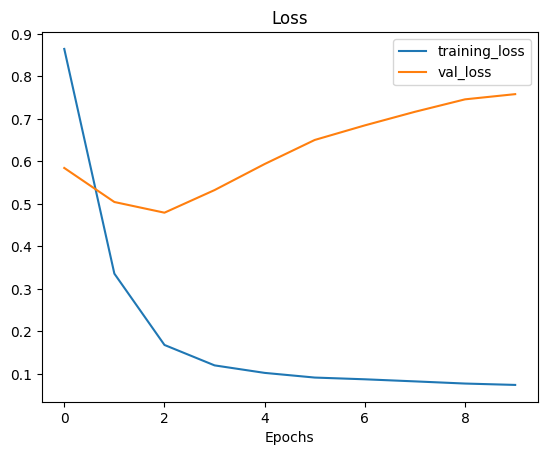

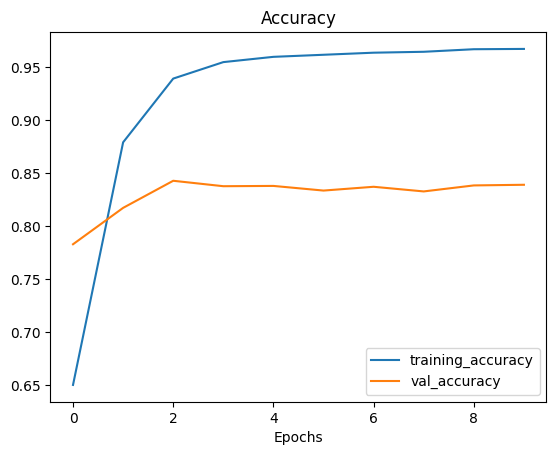

In [49]:
plot_loss_curves(model_3_history)

## Model 4

In [69]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer
x = layers.Dense(8, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_conv1d')

model_4.compile(
   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
   metrics=['accuracy']
)

model_4.summary()


Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 19, 128)           98816     
 onal)                                                           
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 32)            20512     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 32)             

In [70]:
model_4_history = model_4.fit(train_sentences,
                              train_labels_encoded,
                              epochs=5,  # Increase the number of epochs
                              validation_data=(val_sentences, val_labels_encoded))

Epoch 1/5
1850/1850 [==============================] - 43s 19ms/step - loss: 0.6563 - accuracy: 0.7476 - val_loss: 0.6581 - val_accuracy: 0.8169
Epoch 2/5
1850/1850 [==============================] - 22s 12ms/step - loss: 0.3516 - accuracy: 0.8765 - val_loss: 0.6949 - val_accuracy: 0.8306
Epoch 3/5
1850/1850 [==============================] - 24s 13ms/step - loss: 0.2871 - accuracy: 0.9006 - val_loss: 0.7789 - val_accuracy: 0.8261
Epoch 4/5
1850/1850 [==============================] - 21s 12ms/step - loss: 0.2570 - accuracy: 0.9094 - val_loss: 0.7961 - val_accuracy: 0.8307
Epoch 5/5
1850/1850 [==============================] - 22s 12ms/step - loss: 0.2406 - accuracy: 0.9152 - val_loss: 0.7232 - val_accuracy: 0.8286


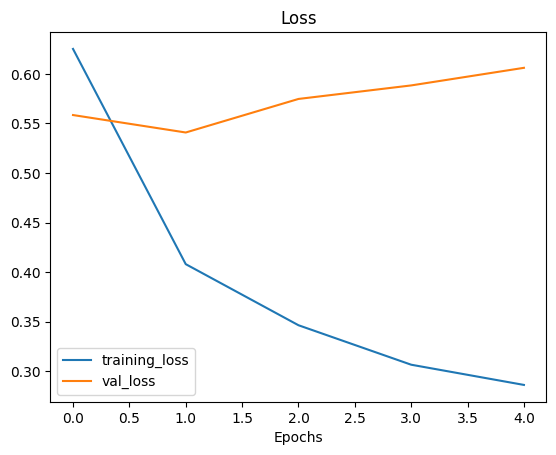

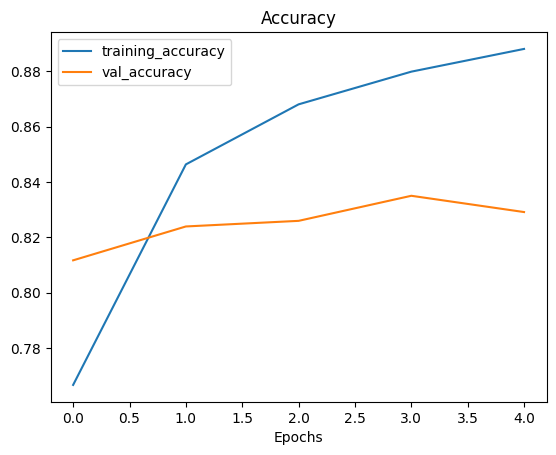

In [68]:
model_4_loss_curves = plot_loss_curves(model_4_history)

In [53]:
model_4_preds = tf.argmax(model_4.predict(val_sentences), axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)

463/463 [==============================] - 3s 4ms/step


In [54]:
model_4_results

{'accuracy': 82.39745928778972,
 'precision': 0.8272422928108105,
 'recall': 0.8239745928778972,
 'f1': 0.8246306477961814}

## Model 5: Try to reduce overfitting

In [55]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add L2 regularization
x = layers.Dropout(0.5)(x)  # Add dropout layer
x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add L2 regularization
x = layers.Dropout(0.5)(x)  # Add dropout layer
outputs = layers.Dense(4, activation='softmax')(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1d')

model_5.compile(
   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
   metrics=['accuracy']
)

model_5.summary()


Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 128)           1280000   
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)             

In [56]:
model_5_history = model_5.fit(train_sentences,
                              train_labels_encoded,
                              epochs=5,  # Increase the number of epochs
                              validation_data=(val_sentences, val_labels_encoded))

Epoch 1/5
1850/1850 [==============================] - 27s 14ms/step - loss: 1.3397 - accuracy: 0.5130 - val_loss: 0.9247 - val_accuracy: 0.7254
Epoch 2/5
1850/1850 [==============================] - 13s 7ms/step - loss: 0.9775 - accuracy: 0.6750 - val_loss: 0.8017 - val_accuracy: 0.7512
Epoch 3/5
1850/1850 [==============================] - 14s 7ms/step - loss: 0.8630 - accuracy: 0.7239 - val_loss: 0.7498 - val_accuracy: 0.7678
Epoch 4/5
1850/1850 [==============================] - 13s 7ms/step - loss: 0.7929 - accuracy: 0.7561 - val_loss: 0.7070 - val_accuracy: 0.7821
Epoch 5/5
1850/1850 [==============================] - 13s 7ms/step - loss: 0.7416 - accuracy: 0.7772 - val_loss: 0.7026 - val_accuracy: 0.7790


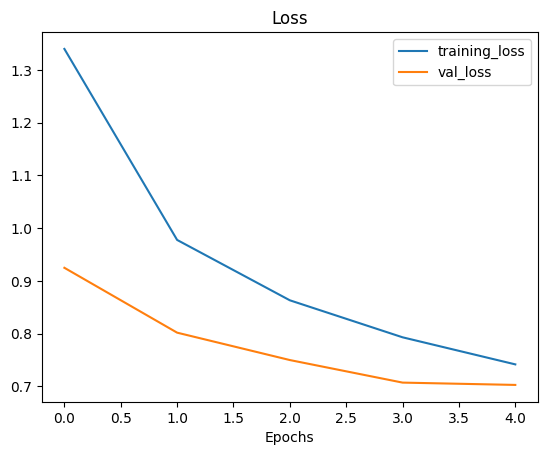

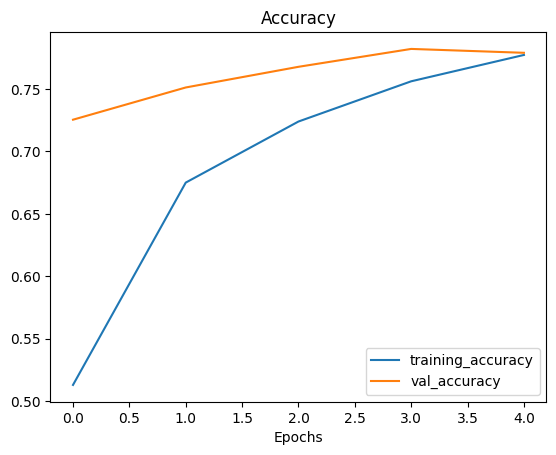

In [57]:
model_5_loss_curves = plot_loss_curves(model_5_history)
model_5_loss_curves

In [58]:
model_5_preds = tf.argmax(model_5.predict(val_sentences), axis=1)

463/463 [==============================] - 1s 3ms/step


In [59]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)

In [60]:
baseline_results

{'accuracy': 73.33603621866342,
 'precision': 0.7739122613984681,
 'recall': 0.7333603621866343,
 'f1': 0.7229200275334022}

## Comparing the performance of each of our models

In [71]:
import pandas as pd
all_model_results = pd.DataFrame({
    'baseline': baseline_results,
    'model_2': model_2_results,
    'model_3': model_3_results,
    'model_4': model_4_results,
    'model_5': model_5_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,73.336036,0.773912,0.733360,0.722920
model_2,73.950943,0.739703,0.739509,0.735676
model_3,83.911075,0.839947,0.839111,0.839112
model_4,82.397459,0.827242,0.823975,0.824631
model_5,77.897155,0.783254,0.778972,0.779200


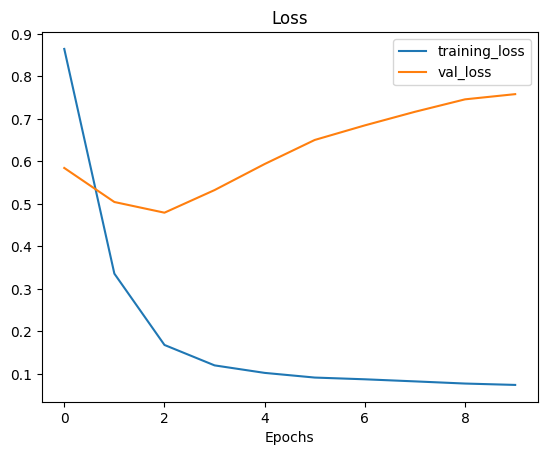

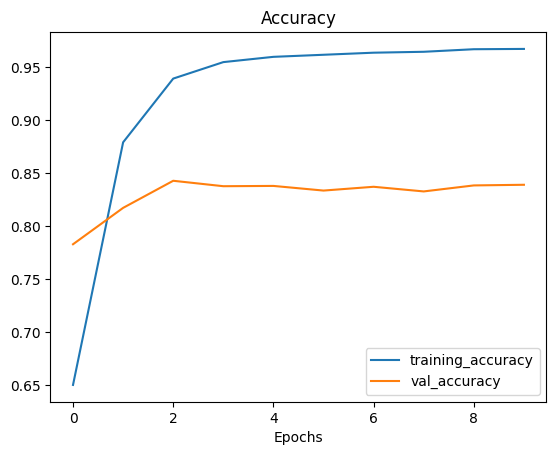

In [72]:
plot_loss_curves(model_3_history) # Model 3 is overfitting, so we are not using ig

In [73]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

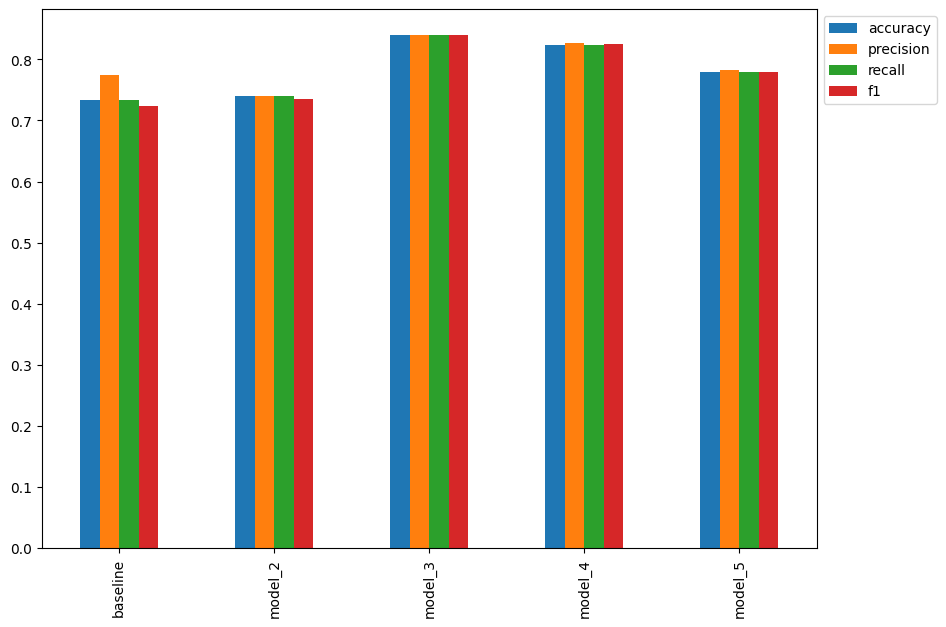

In [74]:

all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


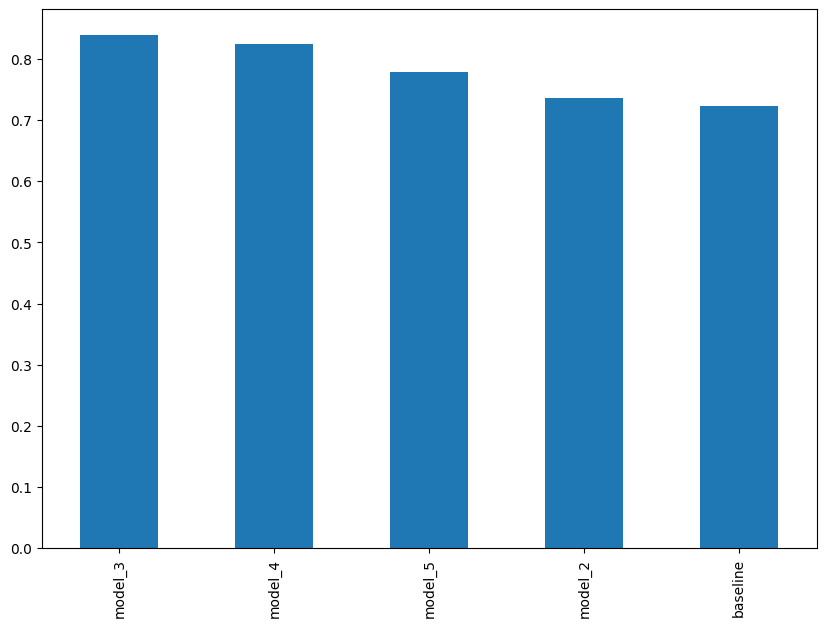

In [75]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


## Finding the most wrong examples

In [81]:
model_5_pred_probs = model_5.predict(val_sentences)



463/463 [==============================] - 3s 6ms/step


array([[0.0189318 , 0.01302923, 0.9587423 , 0.00929664],
       [0.01669955, 0.02009853, 0.02119007, 0.94201183],
       [0.00171864, 0.99159604, 0.00483165, 0.00185364],
       ...,
       [0.26892558, 0.26549193, 0.4408003 , 0.02478218],
       [0.04793748, 0.24595037, 0.6365716 , 0.06954055],
       [0.0285786 , 0.01940517, 0.05853789, 0.89347833]], dtype=float32)

In [82]:
model_5_pred_probs[:10]

array([[0.0189318 , 0.01302923, 0.9587423 , 0.00929664],
       [0.01669955, 0.02009853, 0.02119007, 0.94201183],
       [0.00171864, 0.99159604, 0.00483165, 0.00185364],
       [0.10764781, 0.08670101, 0.08374972, 0.7219015 ],
       [0.31461504, 0.3820283 , 0.20907566, 0.094281  ],
       [0.0954555 , 0.07257461, 0.15707116, 0.67489874],
       [0.26005346, 0.11019339, 0.10350251, 0.52625066],
       [0.1409757 , 0.08008096, 0.11821067, 0.6607327 ],
       [0.0326732 , 0.01953006, 0.04412067, 0.90367603],
       [0.02111977, 0.02196755, 0.02681916, 0.93009347]], dtype=float32)

In [83]:
tf.squeeze(model_5_pred_probs)[:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0.0189318 , 0.01302923, 0.9587423 , 0.00929664],
       [0.01669955, 0.02009853, 0.02119007, 0.94201183],
       [0.00171864, 0.99159604, 0.00483165, 0.00185364],
       [0.10764781, 0.08670101, 0.08374972, 0.7219015 ],
       [0.31461504, 0.3820283 , 0.20907566, 0.094281  ],
       [0.0954555 , 0.07257461, 0.15707116, 0.67489874],
       [0.26005346, 0.11019339, 0.10350251, 0.52625066],
       [0.1409757 , 0.08008096, 0.11821067, 0.6607327 ],
       [0.0326732 , 0.01953006, 0.04412067, 0.90367603],
       [0.02111977, 0.02196755, 0.02681916, 0.93009347]], dtype=float32)>

In [96]:
pred_probs_values = tf.squeeze(model_5_pred_probs).numpy()
pred_probs_values.shape

(14799, 4)

In [100]:
val_df = pd.DataFrame({
    'text': val_sentences,
    'target': val_labels,
    'target_encoded': val_labels_encoded,
    'pred': model_5_preds,
       'pred_prob_0': pred_probs_values[:, 0],
    'pred_prob_1': pred_probs_values[:, 1]
})
val_df

,text,target,target_encoded,pred,pred_prob_0,pred_prob_1
0,We are pleased to announce that Dave Matthews ...,Neutral,2,2,0.018932,0.013029
1,Finally I downloaded GTA 5 on my new Xbox One.,Positive,3,3,0.016700,0.020099
2,@PUBG hi I m facing some in game problem where...,Negative,1,1,0.001719,0.991596
3,I really forgot how fun GTA 2011 is,Positive,3,3,0.107648,0.086701
4,The latter tells us what we need to know about...,Irrelevant,0,0,0.314615,0.382028
...,...,...,...,...,...,...
14794,I stand by what I said. It is all because of m...,Irrelevant,0,0,0.980000,0.004346
14795,The way the new league is having so much fun.,Positive,3,3,0.059726,0.084316
14796,Dirty casual spam monitoring junkie for skins?...,Negative,1,2,0.268926,0.265492
14797,I apologize for any inconvenience these change...,Irrelevant,0,1,0.047937,0.245950


In [103]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target_encoded"] != val_df["pred"]].sort_values("pred_prob_0", ascending=False)
most_wrong[:10]

,text,target,target_encoded,pred,pred_prob_0,pred_prob_1
9543,Editions [UNK].,Negative,1,0,0.984274,0.004376
6534,damnnnn ng,Negative,1,0,0.972139,0.006785
9252,? @ CSGO. Why does my POV sometimes twist so m...,Neutral,2,0,0.971318,0.004149
6693,was a bad night tonight. First night on warzon...,Positive,3,0,0.968091,0.006639
10901,"It's nice that I no longer have Facebook, but ...",Neutral,2,0,0.967645,0.005913
11507,they will shave their legs but lie about overc...,Neutral,2,0,0.965314,0.008656
8442,I am her cousin dota 2 i meme great big stuff ...,Neutral,2,0,0.960383,0.002955
2068,Going live in 5 Mins! Going to play Battlefiel...,Positive,3,0,0.958386,0.010213
12457,Going live in 5 Mins! Going to play Battlefiel...,Positive,3,0,0.958386,0.010213
2326,Imagine hating<unk> somebody while having a go...,Neutral,2,0,0.953194,0.012250


In [110]:
val_labels_encoded[:10], val_labels[:10]

(array([2, 3, 1, 3, 0, 3, 0, 3, 3, 3]),
 array(['Neutral', 'Positive', 'Negative', 'Positive', 'Irrelevant',
        'Positive', 'Irrelevant', 'Positive', 'Positive', 'Positive'],
       dtype=object))

In [106]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, target_encoded, pred, prob, _ = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: Negative, Pred: 0, Prob: 0.9842744469642639
Text:
Editions [UNK].

----

Target: Negative, Pred: 0, Prob: 0.9721388220787048
Text:
damnnnn ng

----

Target: Neutral, Pred: 0, Prob: 0.9713183045387268
Text:
? @ CSGO. Why does my POV sometimes twist so much when I drop it and turn away? pic.facebook.com / tLc6lz7

----

Target: Positive, Pred: 0, Prob: 0.968090832233429
Text:
was a bad night tonight. First night on warzone I’ve enjoyed about a decade! Little squad wipe on this trio

----

Target: Neutral, Pred: 0, Prob: 0.9676454067230225
Text:
It's nice that I no longer have Facebook, but I can't say I hate it when my cousin tells me the latest drama.

----

Target: Neutral, Pred: 0, Prob: 0.9653141498565674
Text:
they will shave their legs but lie about overcooking salmon. Mf you’re worried about the fat person 5.

----

Target: Neutral, Pred: 0, Prob: 0.9603828191757202
Text:
I am her cousin dota 2 i meme great big stuff - To Casey

----

Target: Positive, Pred: 0, Prob: 0.958

In [115]:
test_sample = 'this suscks'

tf.squeeze(model_5.predict([test_sample]))


1/1 [==============================] - 0s 34ms/step


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.23202692, 0.19586252, 0.2929135 , 0.27919713], dtype=float32)>

In [126]:
val_labels_encoded[:10], val_labels[:10]

(array([2, 3, 1, 3, 0, 3, 0, 3, 3, 3]),
 array(['Neutral', 'Positive', 'Negative', 'Positive', 'Irrelevant',
        'Positive', 'Irrelevant', 'Positive', 'Positive', 'Positive'],
       dtype=object))

In [129]:
# Making predictions on the test dataset
test_sentences = val_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_5.predict([test_sample]))  # has to be a list
    pred = tf.round(pred_prob)

    # Get the true target from val_df
    true_target = val_df[val_df["text"] == test_sample]["target"].values[0]

    print(f"Pred: {tf.argmax(pred)}, Prob: {tf.round(pred_prob)}, True Target: {true_target}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")

1/1 [==============================] - 0s 164ms/step
Pred: 3, Prob: [0. 0. 0. 1.], True Target: Positive
Text:
I love when my own clients show up in my insta and google ads just cause I visit their sites a lot. waste those ad dollars bitch

----

1/1 [==============================] - 0s 116ms/step
Pred: 3, Prob: [0. 0. 0. 1.], True Target: Positive
Text:
'That was really an Assassin's Creed. '

----

1/1 [==============================] - 0s 125ms/step
Pred: 0, Prob: [1. 0. 0. 0.], True Target: Irrelevant
Text:
Happy birthday Laura.

----

1/1 [==============================] - 0s 66ms/step
Pred: 2, Prob: [0. 0. 1. 0.], True Target: Negative
Text:
Sad Battlefield fan fiction is sad : (

----

1/1 [==============================] - 0s 127ms/step
Pred: 1, Prob: [0. 1. 0. 0.], True Target: Negative
Text:
Your Facebook creating hiding places place love abusers e-activist.com/page/52739/pet... by]

----

1/1 [==============================] - 0s 138ms/step
Pred: 3, Prob: [0. 0. 0. 1.], Tru

In [146]:
val_labels_encoded[:10], val_labels[:10]

(array([2, 3, 1, 3, 0, 3, 0, 3, 3, 3]),
 array(['Neutral', 'Positive', 'Negative', 'Positive', 'Irrelevant',
        'Positive', 'Irrelevant', 'Positive', 'Positive', 'Positive'],
       dtype=object))

In [143]:

def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {tf.argmax(pred_label)}", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [152]:
tweet = 'Woohoo! Our model predicted correctly. My Tweet was not about a diaster.'
predict_on_sentence(model=model_5, # use the USE model
                    sentence=tweet)

1/1 [==============================] - 0s 52ms/step
Pred: 1 Prob: 0.06048741191625595
Text:
Woohoo! Our model predicted correctly. My Tweet was not about a diaster.
